# Exploratory Data Analysis - Hard Drive Life Expectancy

#### Dataset Description
Since 2013, [Backblaze](https://www.backblaze.com/) has published statistics and insights based on the hard drives in their data center. They publish the data underlying their reports, so that anyone can reproduce them. A more in depth look into the context, content, and acknowledgments for this dataset can be found [here](https://www.backblaze.com/b2/hard-drive-test-data.html#downloading-the-raw-hard-drive-test-data).

#### Variable Descriptions
Format: `variable` (type) - description
- `date` () - The date of the file in yyyy-mm-dd format.
- `sn`  () - The manufacturer-assigned serial number of the drive.
- `model` () - The manufacturer-assigned model number of the drive.
        WD... = Western Digital
        ST... = Seagate
        HD... = Deskstar
        TOSHIBA... = Toshiba
- `cap_b` () - The drive capacity in bytes (1 byte = 8 bits)
- `cap_gb` () = The drive capacity in gigabytes. (1 GB = 1,000,000,000 bytes)
- `cap_tb` () = The drive capacity in terabytes. (1 TB = 1000 GB)
- `failure` () = Contains a “0” if the drive is OK. Contains a “1” if this is the last day the drive was operational before failing.

The following are the Raw and Normalized values for 8 currated SMART stats as reported by the given drive. Each value is the number reported by the drive.

**S.M.A.R.T.** (Self-Monitoring, Analysis, and Reporting Technology) is a monitoring technology supported by most of the modern hard drives. With this technology different internal and external problems of a disk (such as a number of bad blocks, increasing number of errors or start/stop cycles, rising airflow temperature, and so on) may be monitored and reported to the user in good time. Some of the electro-mechanical problems reported by S.M.A.R.T. may lead to an imminent hard drive failure and data loss. Other parameters informs about potential problems with a disk in the future and do not require immediate actions to be taken.

Statistically S.M.A.R.T. can predict more than a half of all hard drive failures, which makes this technology a reliable source of information about current hard disk state. But anyway, such monitoring does not substitute the necessity of keeping up-to-date backups for your data. Such backup archives will protect you from crucial data loss in case of logical corruption, physical damaging, destroying or even loosing the hardware, which cannot be predicted by any kind of monitoring.

S.M.A.R.T. parameters describe specific aspects of the hard disk state – surface damages, read/write errors, problems with electro-mechanical components, etc. When a value of a parameter considered critical decreases, a disk failure probability raises up to 30 times. This means a crash may happen in a near future and you need an urgent hardware replacement to avoid crucial data loss.

Each hardware manufacturer supports its own set of S.M.A.R.T. parameters, which may also differ from one disk model to another.

The ones that interest me are as follows:

- `smart_5` () - **Reallocated Sector Count** - SMART parameter indicates the count of reallocated sectors (512 bytes). When the hard drive finds a read/write/verification error, it marks this sector as "reallocated" and transfers data to a special reserved area (spare area). This process is also known as remapping and "reallocated" sectors are called remaps. This is why, on a modern hard disks, you will not see "bad blocks" while testing the surface - all bad blocks are hidden in reallocated sectors.

However, the more sectors that are reallocated, the more a sudden decrease (up to 10% and more) can be noticed in the disk read/write speed.

- `smart_9` () - **Power-On Hours (POH)** - SMART parameter indicates a count of hours in power-on state. The value of this attribute shows total count of hours (or minutes, or seconds, depending on manufacturer) in power-on state. A decrease of this attribute value to the critical level (threshold) indicates a decrease of the MTBF (Mean Time Between Failures).
- `smart_12` () - **Power Cycle Count** - SMART parameter is an informational parameter and indicates the count of full hard disk power on/off cycles.
- `smart187` () - **Reported Uncorrectable Errors** - SMART parameter indicates a number of errors that could not be recovered using hardware ECC (error-correcting code).
- `smart188` () - **Command Timeout** - SMART parameter indicates a number of aborted operations due to hard disk timeout.
- `smart189` () - **High Fly Writes** - SMART parameter indicates the count of these errors detected over the lifetime of the drive. HDD producers implement a Fly Height Monitor that attempts to provide additional protections for write operations by detecting when a recording head is flying outside its normal operating range. If an unsafe fly height condition is encountered, the write process is stopped, and the information is rewritten or reallocated to a safe region of the hard drive.
- `smart_197` () - **Current Pending Sector Count** - SMART parameter is a critical parameter and indicates the current count of unstable sectors (waiting for remapping). The raw value of this attribute indicates the total number of sectors waiting for remapping. Later, when some of these sectors are read successfully, the value is decreased. If errors still occur when reading some sector, the hard drive will try to restore the data, transfer it to the reserved disk area (spare area) and mark this sector as remapped.
- `smart_198` () - **Uncorrectable Sector Count** - SMART parameter is a critical parameter and indicates the quantity of uncorrectable errors. The raw value of this attribute indicates the total number of uncorrectable errors when reading/writing a sector.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats.mstats import winsorize
from sklearn.decomposition import PCA
from sklearn.preprocessing import scale
from sqlalchemy import create_engine
from menning import menning_ds as mds
import os
import warnings

# warnings.filterwarnings('ignore')
sns.set(style="whitegrid")

print(pd.__version__)

1.0.3


## Loading Data

Bringing in the harddrive dataset, as the Backblaze data is too big for my laptop.

In [2]:
df_raw = pd.read_csv('drive_stats_2019_Q1_interested.csv')

Making a copy so I don't have reimport again along with some changes I know I need to make.

In [3]:
df = df_raw.copy()
# Dropping columns I realize I don't need
df = df.drop(columns=['Unnamed: 0',
                    'smart_5_normalized',
                    'smart_9_normalized',
                    'smart_12_normalized',
                    'smart_187_normalized',
                    'smart_188_normalized',
                    'smart_189_normalized',
                    'smart_197_normalized',
                    'smart_198_normalized'])
# Changing some dtypes
df['date'] = pd.to_datetime(df.date, format='%Y-%m-%d')
#df['failure'] = df['failure'].astype('bool')
#df['smart_5_raw'].astype(np.int64)
#df['smart_9_raw'].astype(np.int64)
#df['smart_12_raw'].astype(np.int64)
#df['smart_187_raw'].astype(np.int64)
#df['smart_188_raw'].astype(np.int64)
#df['smart_189_raw'].astype(np.int64)
#df['smart_197_raw'].astype(np.int64)
#df['smart_198_raw'].astype(np.int64)

# Adding couple other columns then moving them
df['capacity_gigabytes'] = df.capacity_bytes // 1000000000
df['capacity_terabytes'] = df.capacity_gigabytes // 1000

# Using useful custom function from my menning_ds file
df = mds.movecol(df, 
             cols_to_move=['capacity_gigabytes','capacity_terabytes'], 
             ref_col='capacity_bytes',
             place='After')

# Renaming columns
new_columns = {
    'serial_number': 'sn',
    'capacity_bytes': 'cap_b',
    'capacity_gigabytes': 'cap_gb',
    'capacity_terabytes': 'cap_tb',
    'smart_5_raw':'realloc_sc', # Reallocated Sector Count
    'smart_9_raw':'power_oh', #Power-On Hours
    'smart_12_raw':'power_cc', #Power Cycle Count
    'smart_187_raw':'uncorr_errors', #Uncorrectable Errors
    'smart_188_raw':'command_to', # Command Timeouts
    'smart_189_raw':'hf_writes', # High-Fly Writes
    'smart_197_raw':'pending_sc', # Current Pending Sector Count
    'smart_198_raw':'uncorr_sc' # Uncorrectable Sector Count
}
df.rename(columns=new_columns, inplace=True)

Check it out

In [4]:
print(df.shape)
df.head()

(9577046, 15)


,date,sn,model,cap_b,cap_gb,cap_tb,failure,realloc_sc,power_oh,power_cc,uncorr_errors,command_to,hf_writes,pending_sc,uncorr_sc
0,2019-01-01,Z305B2QN,ST4000DM000,4000787030016,4000,4,0,0.0,26712.0,12.0,0.0,0.0,0.0,0.0,0.0
1,2019-01-01,ZJV0XJQ4,ST12000NM0007,12000138625024,12000,12,0,0.0,3753.0,2.0,0.0,0.0,NaN,0.0,0.0
2,2019-01-01,ZJV0XJQ3,ST12000NM0007,12000138625024,12000,12,0,0.0,792.0,1.0,0.0,0.0,NaN,0.0,0.0
3,2019-01-01,ZJV0XJQ0,ST12000NM0007,12000138625024,12000,12,0,0.0,4356.0,6.0,0.0,0.0,NaN,0.0,0.0
4,2019-01-01,PL1331LAHG1S4H,HGST HMS5C4040ALE640,4000787030016,4000,4,0,0.0,16788.0,8.0,NaN,NaN,NaN,0.0,0.0


Creating second DataFrame where `failure` == 1

In [5]:
df_fail = df.loc[df.failure == 1]
print(df_fail.shape)

(444, 15)


## Detect Problems

### Nonsense

### Missing Values

#### Full DF

In [6]:
mds.nulls_breakdown(df)

[iloc = 7] realloc_sc has 3363 null values: 0.04% null
[iloc = 8] power_oh has 1534 null values: 0.02% null
[iloc = 9] power_cc has 1534 null values: 0.02% null
[iloc = 10] uncorr_errors has 2182118 null values: 22.78% null
[iloc = 11] command_to has 2182118 null values: 22.78% null
[iloc = 12] hf_writes has 5136912 null values: 53.64% null
[iloc = 13] pending_sc has 3363 null values: 0.04% null
[iloc = 14] uncorr_sc has 3363 null values: 0.04% null

Out of 15 total columns, 8 contain null values; 53.33% columns contain null values.


So we see 50% of the data is null, mostly from high_fly_writes column along with uncorrectable_errors and command_timeout. Given that not all hard-drives monitor for high_fly_writes, that could account for why majority of the data in that column is null.

Interpolating as many missing information I can grouping by `Serial Number` aka individual drives

In [7]:
#df_inter = df.groupby(['sn'], sort=False).apply(
#    lambda group: group.interpolate(method='linear', limit_direction='both'))
#df_inter = df_inter.drop(columns=['Unnamed: 0'])
#df_inter.to_csv('drive_stats_2019_Q1_interpolated.csv')

# I've already done the interpolation, which took 15 minutes.
# To save time, I'll just import what was done earlier on future runs.
df_inter = pd.read_csv('drive_stats_2019_Q1_interpolated.csv').drop(columns=['Unnamed: 0'])

In [8]:
mds.nulls_breakdown(df_inter)

[iloc = 7] realloc_sc has 2369 null values: 0.02% null
[iloc = 8] power_oh has 540 null values: 0.01% null
[iloc = 9] power_cc has 540 null values: 0.01% null
[iloc = 10] uncorr_errors has 2181647 null values: 22.78% null
[iloc = 11] command_to has 2181647 null values: 22.78% null
[iloc = 12] hf_writes has 5136672 null values: 53.64% null
[iloc = 13] pending_sc has 2369 null values: 0.02% null
[iloc = 14] uncorr_sc has 2369 null values: 0.02% null

Out of 15 total columns, 8 contain null values; 53.33% columns contain null values.


Although it took out nearly 6000 nulls, the core percentage hasn't nudged.  Not too surprising considering there's almost 9-million rows.

I am going to make the decision to remove all rows with nulls.  It will lead to a bias of removing hard-drives that do not record `high_fly_writes`, but I think half of 9-million rows is more than adequate to run some models.  It'll also speed up future tests.

If I am to run things like this again, I would like to run different methods or removing nulls.

In [10]:
print(df_inter.shape)
df_dropped = df_inter.dropna()
print(df_dropped.shape)

(9577046, 15)
(4440374, 15)


In [12]:
mds.nulls_breakdown(df_dropped)


Out of 15 total columns, 0 contain null values; 0.0% columns contain null values.


#### Failed DF

In [13]:
mds.nulls_breakdown(df_fail)

[iloc = 7] realloc_sc has 1 null values: 0.23% null
[iloc = 8] power_oh has 1 null values: 0.23% null
[iloc = 9] power_cc has 1 null values: 0.23% null
[iloc = 10] uncorr_errors has 57 null values: 12.84% null
[iloc = 11] command_to has 57 null values: 12.84% null
[iloc = 12] hf_writes has 237 null values: 53.38% null
[iloc = 13] pending_sc has 1 null values: 0.23% null
[iloc = 14] uncorr_sc has 1 null values: 0.23% null

Out of 15 total columns, 8 contain null values; 53.33% columns contain null values.


So we see 50% of the data is null, mostly from `high_fly_writes` column along with `uncorrectable_errors` and `command_timeout`.  Given that not all hard-drives monitor for high_fly_writes, that could account for why majority of the data in that column is null.

Let's see if interpolated data helped.

In [14]:
df_fail = df_inter.loc[df_inter.failure == 1]
print(df_fail.shape)

(444, 15)


In [15]:
mds.nulls_breakdown(df_fail)

[iloc = 10] uncorr_errors has 56 null values: 12.61% null
[iloc = 11] command_to has 56 null values: 12.61% null
[iloc = 12] hf_writes has 236 null values: 53.15% null

Out of 15 total columns, 3 contain null values; 20.0% columns contain null values.


Replaced nulls with 0.

In [16]:
df_fail = df_fail.fillna(0)
mds.nulls_breakdown(df_fail)


Out of 15 total columns, 0 contain null values; 0.0% columns contain null values.


### Outliers

So, I narrowed down the dataset from 9.5M to only 4.4M.  Time to check for outliers.

#### Full DF

In [17]:
cont_vars = list(df_dropped.columns)[7:]

def outliers_visual(data):
    plt.figure(figsize=(15, 40))
    i = 0
    for col in cont_vars:
        i += 1
        plt.subplot(9, 4, i)
        plt.boxplot(data[col])
        plt.title('{} boxplot'.format(col))
        i += 1
        plt.subplot(9, 4, i)
        plt.hist(data[col])
        plt.title('{} histogram'.format(col))
    plt.show()

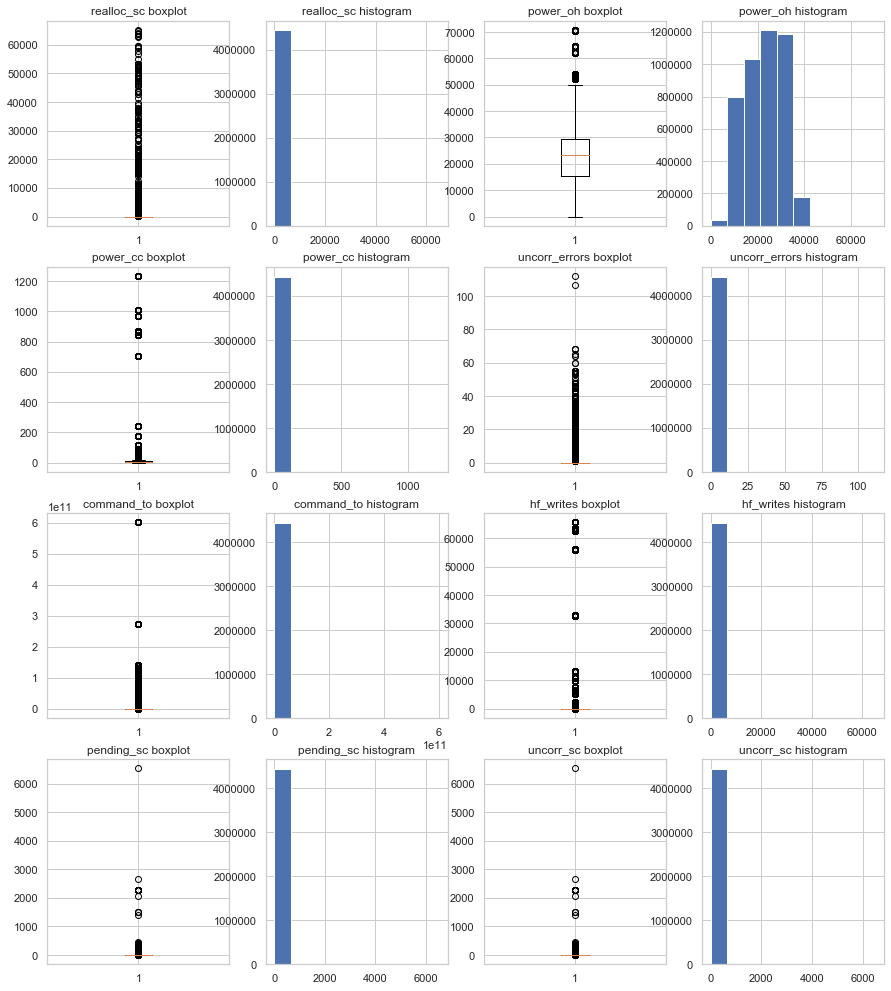

In [18]:
outliers_visual(df_dropped)

Okay, so there's a ton of them that are 0.  Let's see this numerically.

In [20]:
smart_column_list = [
    'realloc_sc',
    'power_oh',
    'power_cc',
    'uncorr_errors',
    'command_to',
    'hf_writes',
    'pending_sc',
    'uncorr_sc']

In [21]:
for col in smart_column_list:
    mds.outlier_count(col, df_dropped)

---------------realloc_sc---------------
Number of outliers: 102337
Min Acceptable Value: 0.0
Max Acceptable Value: 0.0
Percent of data that is outlier: 2.3%
---------------power_oh---------------
Number of outliers: 141
Min Acceptable Value: -5510.5
Max Acceptable Value: 50069.5
Percent of data that is outlier: 0.0%
---------------power_cc---------------
Number of outliers: 205148
Min Acceptable Value: -4.5
Max Acceptable Value: 15.5
Percent of data that is outlier: 4.62%
---------------uncorr_errors---------------
Number of outliers: 70825
Min Acceptable Value: 0.0
Max Acceptable Value: 0.0
Percent of data that is outlier: 1.6%
---------------command_to---------------
Number of outliers: 109323
Min Acceptable Value: 0.0
Max Acceptable Value: 0.0
Percent of data that is outlier: 2.46%
---------------hf_writes---------------
Number of outliers: 277994
Min Acceptable Value: 0.0
Max Acceptable Value: 0.0
Percent of data that is outlier: 6.26%
---------------pending_sc---------------
Numb

Not too many outliers.  What's also interesting is that most things considered outliers are actual data we are interested in.  Perhaps winsorizing the data is not what we want to do, as it will bring everything to 0.

#### Failures

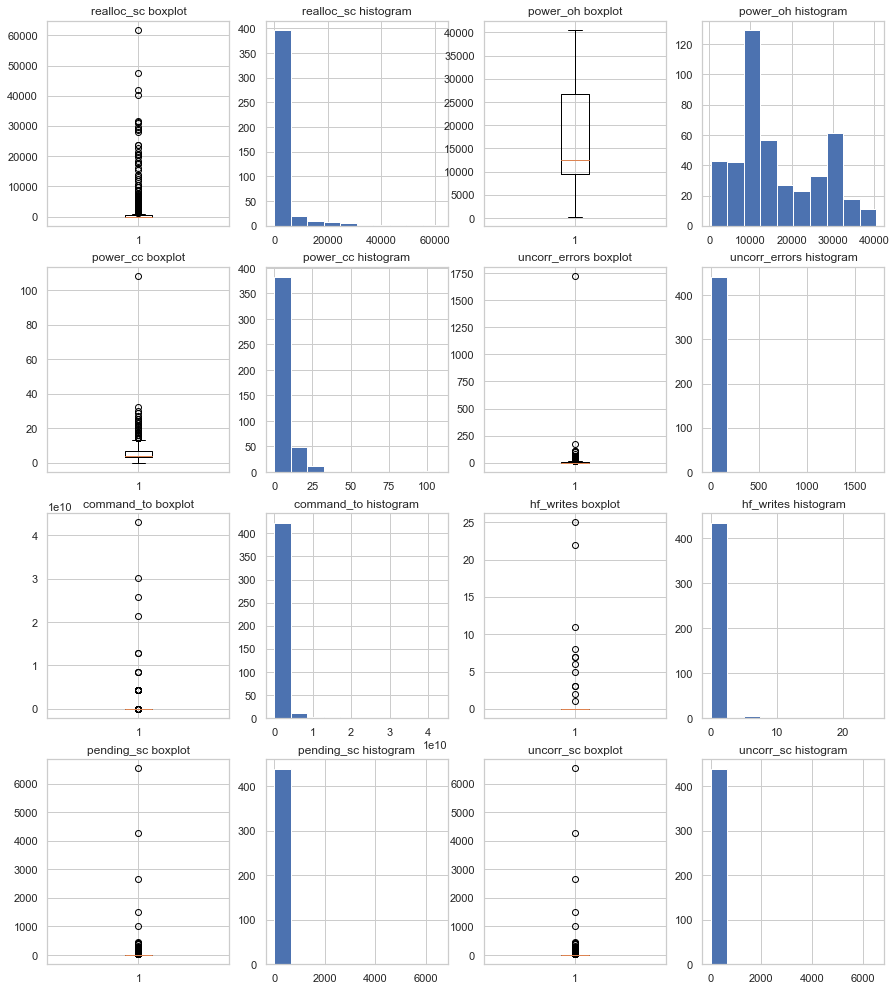

In [22]:
cont_vars = list(df_fail.columns)[7:]

outliers_visual(df_fail)

In [23]:
for col in smart_column_list:
    mds.outlier_count(col, df_fail)

---------------realloc_sc---------------
Number of outliers: 90
Min Acceptable Value: -615.75
Max Acceptable Value: 1026.25
Percent of data that is outlier: 20.27%
---------------power_oh---------------
Number of outliers: 0
Min Acceptable Value: -16034.5
Max Acceptable Value: 52249.5
Percent of data that is outlier: 0.0%
---------------power_cc---------------
Number of outliers: 41
Min Acceptable Value: -3.0
Max Acceptable Value: 13.0
Percent of data that is outlier: 9.23%
---------------uncorr_errors---------------
Number of outliers: 64
Min Acceptable Value: -7.5
Max Acceptable Value: 12.5
Percent of data that is outlier: 14.41%
---------------command_to---------------
Number of outliers: 32
Min Acceptable Value: 0.0
Max Acceptable Value: 0.0
Percent of data that is outlier: 7.21%
---------------hf_writes---------------
Number of outliers: 12
Min Acceptable Value: 0.0
Max Acceptable Value: 0.0
Percent of data that is outlier: 2.7%
---------------pending_sc---------------
Number of o

Not too many outliers, but more than the full data.  What's interesting is that most things considered outliers are actual data we are interested in, so I don't want to remove them willy-nilly.  Perhaps winsorizing the data is not what we want to do, as it will bring everything to 0.

## Data Exploration

Making copy to keep progress

In [24]:
df_win = df_dropped.copy()

In [25]:
df_win.shape

(4440374, 15)

### Descriptive Stats

#### Full Stats

Univariate analysis is looking at the data for each variable on its own. This is generally done best by using histograms for continuous data, count/barplots for categorical data and of course by getting the descriptive stats by using `.describe()`.

In [26]:
df_win.describe()

,cap_b,cap_gb,cap_tb,failure,realloc_sc,power_oh,power_cc,uncorr_errors,command_to,hf_writes,pending_sc,uncorr_sc
count,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06,4.440374e+06
mean,6.166634e+12,6.165977e+03,6.163752e+00,4.684290e-05,9.266882e+00,2.304929e+04,6.604103e+00,9.254671e-02,1.352181e+08,6.556902e+00,1.396905e-01,1.396905e-01
std,2.057336e+12,2.057424e+03,2.061894e+00,6.844028e-03,4.242942e+02,7.760564e+03,1.590897e+01,1.146810e+00,3.859063e+09,5.128075e+02,6.033615e+00,6.033615e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,4.000787e+12,4.000000e+03,4.000000e+00,0.000000e+00,0.000000e+00,1.533200e+04,3.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,8.001563e+12,8.001000e+03,8.000000e+00,0.000000e+00,0.000000e+00,2.336300e+04,5.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
75%,8.001563e+12,8.001000e+03,8.000000e+00,0.000000e+00,0.000000e+00,2.922700e+04,8.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
max,1.000083e+13,1.000000e+04,1.000000e+01,1.000000e+00,6.516000e+04,7.077000e+04,1.232000e+03,1.120000e+02,6.013057e+11,6.553500e+04,6.536000e+03,6.536000e+03


In [27]:
df_win.describe(include='O')

,date,sn,model
count,4440374,4440374,4440374
unique,90,50659,15
top,2019-01-01,ZA16DS34,ST4000DM000
freq,50445,90,1989429


#### Failures

In [28]:
df_fail.describe()

,cap_b,cap_gb,cap_tb,failure,realloc_sc,power_oh,power_cc,uncorr_errors,command_to,hf_writes,pending_sc,uncorr_sc
count,4.440000e+02,444.000000,444.000000,444.0,444.000000,444.000000,444.000000,444.000000,4.440000e+02,444.000000,444.000000,444.000000
mean,7.886056e+12,7885.653153,7.837838,1.0,2346.961712,16478.716216,6.213964,10.013514,5.030245e+08,0.225225,57.146396,56.177928
std,4.069917e+12,4070.072870,4.158356,0.0,6950.966284,10129.212696,7.101755,83.094305,3.200020e+09,1.811350,402.319812,402.371892
min,1.374390e+11,137.000000,0.000000,1.0,0.000000,356.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
25%,4.000787e+12,4000.000000,4.000000,1.0,0.000000,9572.000000,3.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
50%,8.001563e+12,8001.000000,8.000000,1.0,0.000000,12618.500000,4.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000
75%,1.200014e+13,12000.000000,12.000000,1.0,410.500000,26643.000000,7.000000,5.000000,0.000000e+00,0.000000,8.000000,8.000000
max,1.400052e+13,14000.000000,14.000000,1.0,61752.000000,40512.000000,108.000000,1723.000000,4.295033e+10,25.000000,6536.000000,6536.000000


In [29]:
df_fail.describe(include='O')

,date,sn,model
count,444,444,444
unique,89,444,20
top,2019-02-11,Z304KCJZ,ST12000NM0007
freq,14,1,180


### Univariate Exploration

#### Full Data

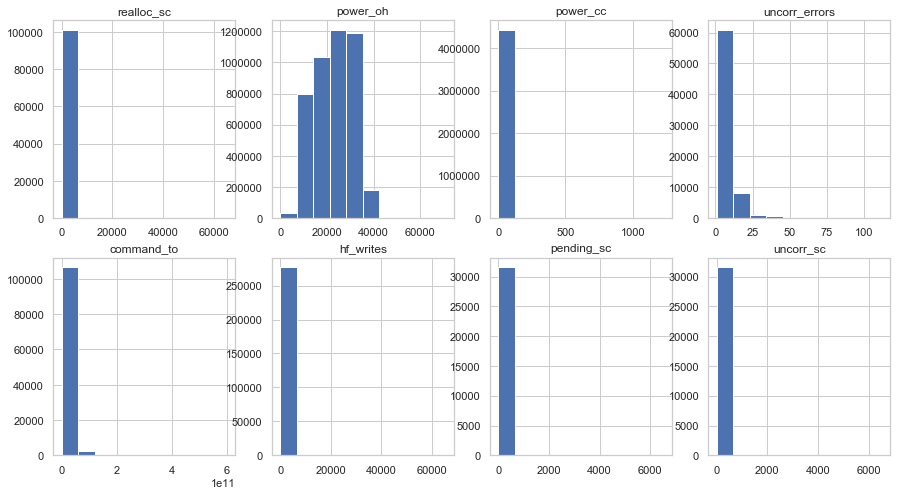

In [30]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 4, i)
    plt.hist(df_win[col].loc[df_win[col]>0]) # After removing all rows that are 0
    plt.title(col)

With so many zeros, the histograms don't help much...

#### Failures

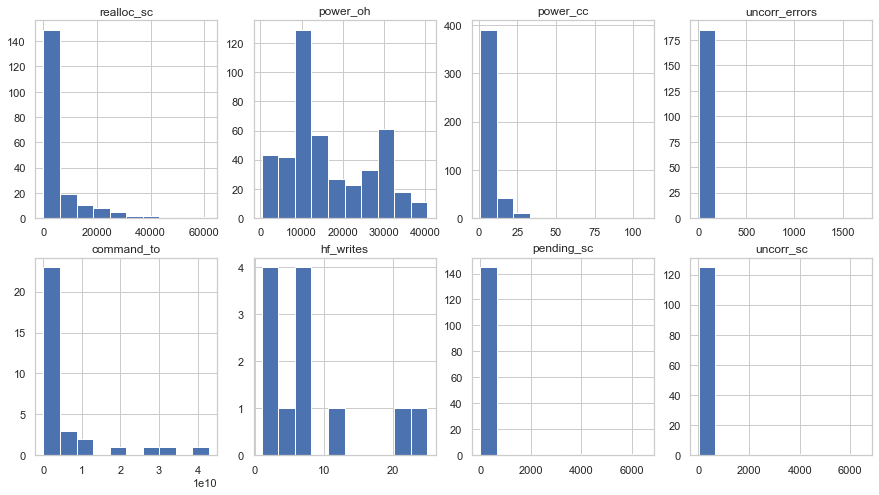

In [32]:
plt.figure(figsize=(15, 8))
for i, col in enumerate(cont_vars, 1):
    plt.subplot(2, 4, i)
    plt.hist(df_fail[col].loc[df_fail[col]>0]) # After removing all rows that are 0
    plt.title(col)

### Multivariate Exploration

There are a number of things that should be examined here:

Continuous variables compared to the failure (target variable) and to one another
Categorical variables compared to the failure (target variable)
Comparison of Failure Status and Year to Continuous variables (country has an extremely large number of values with small sample sizes, so country comparisons aren't especially helpful for this dataset)

#### Full Data

In [33]:
df_win[cont_vars].corr()

,realloc_sc,power_oh,power_cc,uncorr_errors,command_to,hf_writes,pending_sc,uncorr_sc
realloc_sc,1.000000,-0.008901,-0.002892,0.075443,0.007357,-0.000162,0.039499,0.039499
power_oh,-0.008901,1.000000,0.132481,0.047209,-0.056714,0.015966,0.015457,0.015457
power_cc,-0.002892,0.132481,1.000000,0.008607,0.002289,0.002076,0.007009,0.007009
uncorr_errors,0.075443,0.047209,0.008607,1.000000,-0.002612,-0.000969,0.127216,0.127216
command_to,0.007357,-0.056714,0.002289,-0.002612,1.000000,-0.000424,-0.000811,-0.000811
hf_writes,-0.000162,0.015966,0.002076,-0.000969,-0.000424,1.000000,-0.000209,-0.000209
pending_sc,0.039499,0.015457,0.007009,0.127216,-0.000811,-0.000209,1.000000,1.000000
uncorr_sc,0.039499,0.015457,0.007009,0.127216,-0.000811,-0.000209,1.000000,1.000000


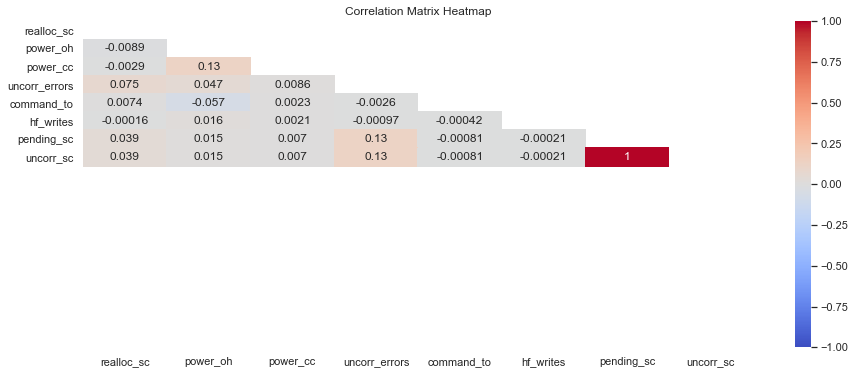

In [34]:
mask = np.triu(df_win[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(df_win[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

#### Failed

In [35]:
df_fail[cont_vars].corr()

,realloc_sc,power_oh,power_cc,uncorr_errors,command_to,hf_writes,pending_sc,uncorr_sc
realloc_sc,1.000000,-0.137972,-0.116848,0.067171,-0.024385,-0.017913,0.018630,0.019437
power_oh,-0.137972,1.000000,0.324659,-0.033110,-0.143732,0.072471,0.084037,0.083587
power_cc,-0.116848,0.324659,1.000000,0.006119,0.007199,0.034325,0.051453,0.051482
uncorr_errors,0.067171,-0.033110,0.006119,1.000000,0.045953,-0.010189,-0.007788,-0.007496
command_to,-0.024385,-0.143732,0.007199,0.045953,1.000000,-0.019590,-0.022077,-0.021695
hf_writes,-0.017913,0.072471,0.034325,-0.010189,-0.019590,1.000000,0.145278,0.145559
pending_sc,0.018630,0.084037,0.051453,-0.007788,-0.022077,0.145278,1.000000,0.999793
uncorr_sc,0.019437,0.083587,0.051482,-0.007496,-0.021695,0.145559,0.999793,1.000000


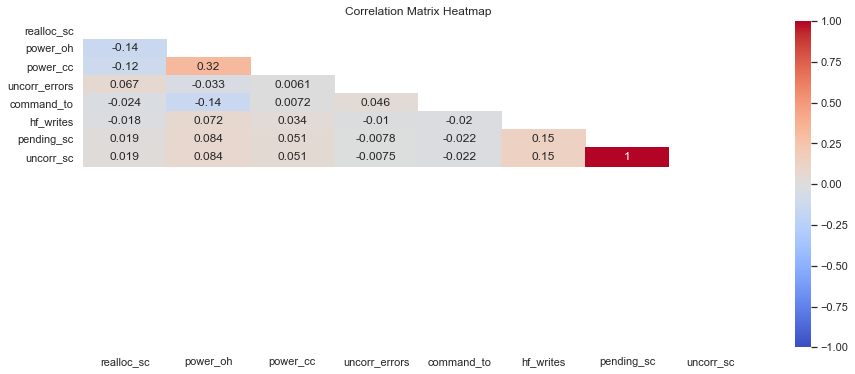

In [36]:
mask = np.triu(df_fail[cont_vars].corr())
plt.figure(figsize=(15,6))
sns.heatmap(df_fail[cont_vars].corr(), annot=True, fmt='.2g', vmin=-1, vmax=1, center=0, cmap='coolwarm', mask=mask)
plt.ylim(18, 0)
plt.title('Correlation Matrix Heatmap')
plt.show()

Well, I guess it's clear, everything is uncorrelated excepted for the last two columns.  Dropping one is fine.

In [37]:
df_win = df_win.drop(columns = ['pending_sc'])
df_fail = df_fail.drop(columns = ['pending_sc'])

### Categorical to Failure

In [39]:
df_fail.groupby('model').failure.agg(['count'])

,count
model,
HGST HMS5C4040ALE640,2
HGST HMS5C4040BLE640,11
HGST HUH721212ALE600,1
HGST HUH721212ALN604,4
HGST HUH728080ALE600,3
ST10000NM0086,3
ST12000NM0007,180
ST4000DM000,107
ST500LM012 HN,12


## Feature Engineering

### Select Ideal Variables

### Discard Unnecessary Variables

#### Extra Correlated

#### Irrelevant

# SL Models